In [1]:
# import modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import zipfile
from zipfile import ZipFile
from urllib.request import urlopen
from sklearn.model_selection import GroupShuffleSplit
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


r_seed = 42

np.random.seed(r_seed)
tf.random.set_seed(r_seed)

In [2]:
## get dataset

URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00344/Activity%20recognition%20exp.zip'

# open and save the zip file
url = urlopen(URL)
output = open('Activity recognition exp.zip', 'wb')
output.write(url.read())
output.close()


zf = zipfile.ZipFile('Activity recognition exp.zip')
## select only sensor data from smart watches
data = pd.read_csv(zf.open('Activity recognition exp/Watch_accelerometer.csv'))

del output

In [3]:
data.shape

(3540962, 10)

In [4]:
data.head()

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696638740,27920678471000,-0.565032,-9.572019,-0.614113,a,gear,gear_1,stand
1,1,1424696638740,27920681910000,-0.832584,-9.713276,-0.606930,a,gear,gear_1,stand
2,2,1424696638740,27920692014000,-1.018134,-9.935339,-0.544082,a,gear,gear_1,stand
3,3,1424696638741,27920701983000,-1.222838,-10.142437,-0.566229,a,gear,gear_1,stand
4,4,1424696638741,27920711906000,-1.577180,-10.480618,-0.402824,a,gear,gear_1,stand


In [5]:
data['gt'].isnull().sum()

520357

In [6]:
#remove the null class
data=data.dropna()

# **Data Exploration**

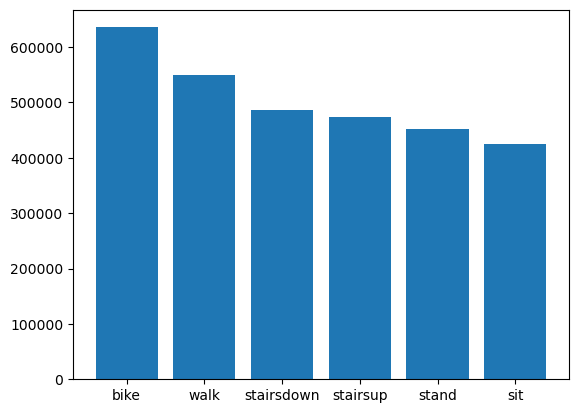

In [7]:
## the distribution of output classes
plt.bar(data["gt"].value_counts().index, data["gt"].value_counts().values)
plt.show()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

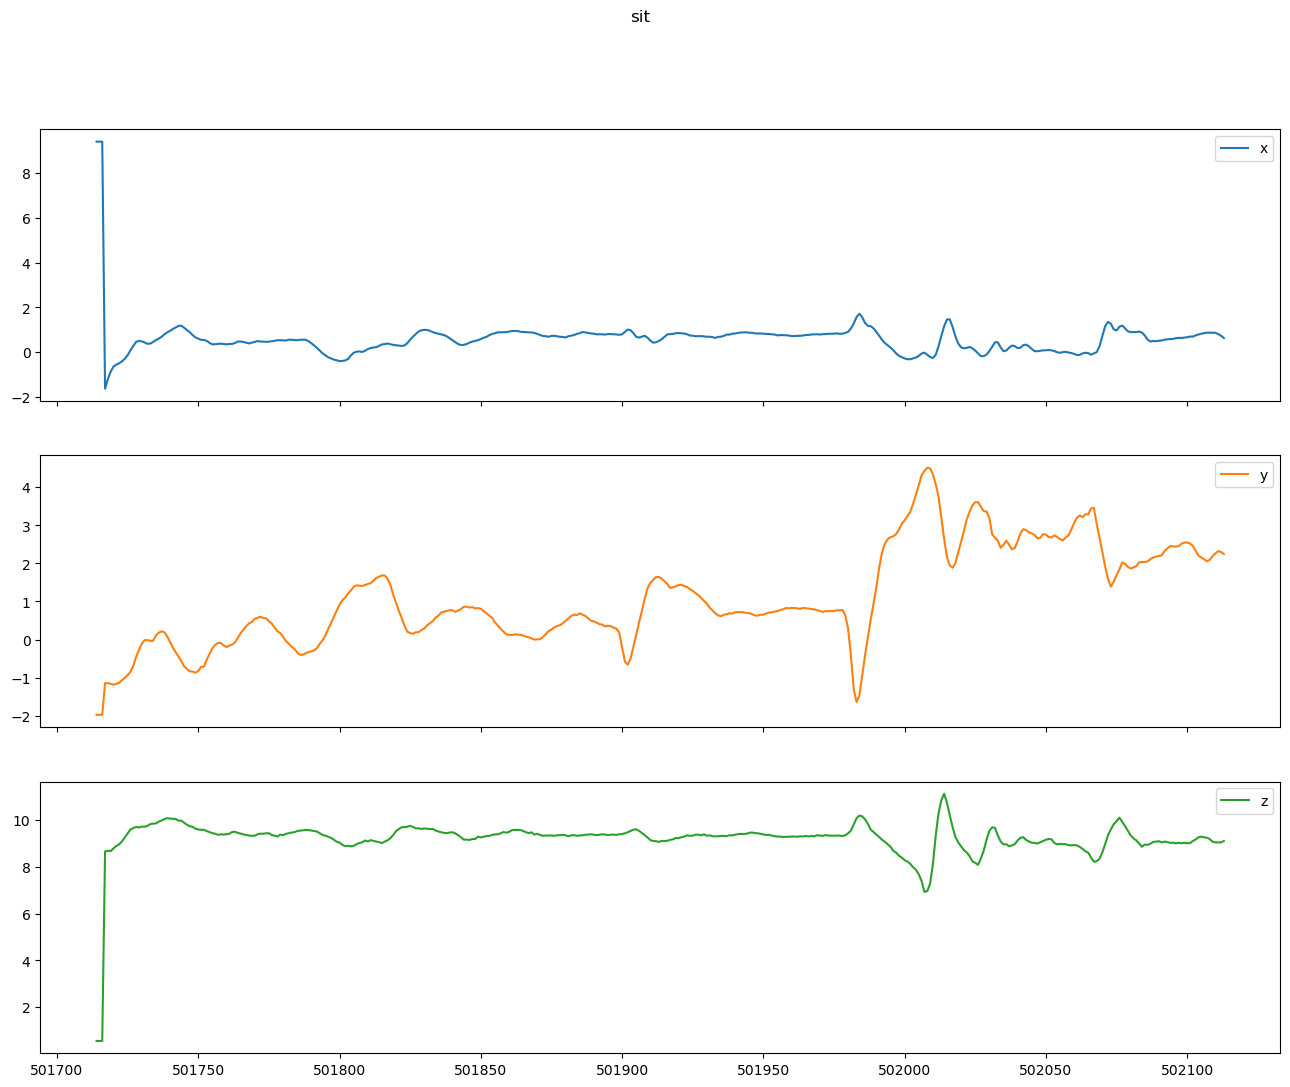

In [8]:
## x,y,z vaues for activity 'sit'
data[(data['gt'] == 'sit')&(data['User']=='b')][['x', 'y', 'z']][:400].plot(title='sit',subplots=True, figsize=(16, 12))

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

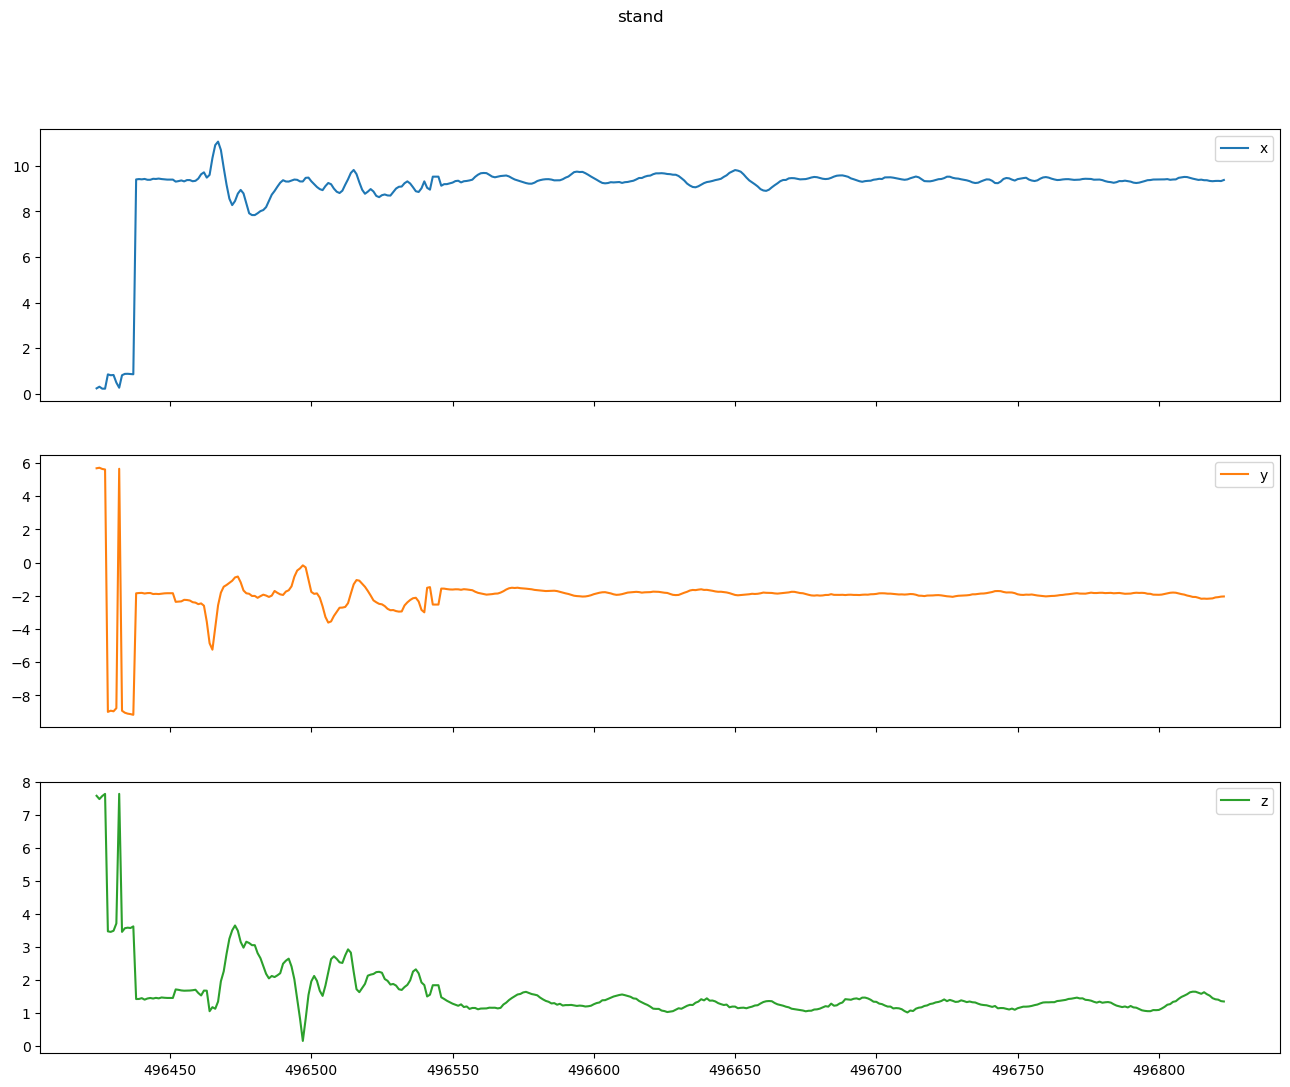

In [9]:
## x,y,z vaues for activity 'stand'
data[(data['gt'] == 'stand')&(data['User']=='b')][['x', 'y', 'z']][:400].plot(title='stand',subplots=True, figsize=(16, 12))

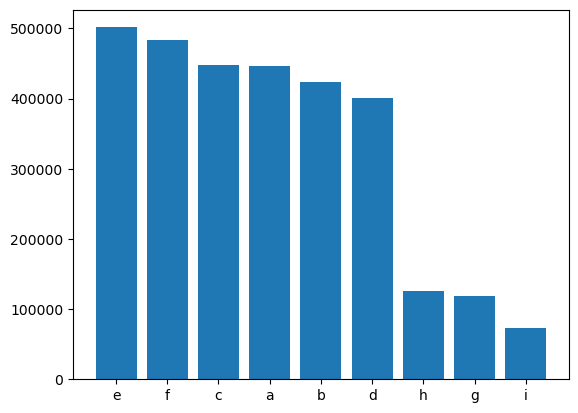

In [10]:
## number of events per user

plt.bar(data["User"].value_counts().index, data["User"].value_counts().values)
plt.show()

# **Models**

In [11]:
## test-train split by keeping 80% for training and 20% for testing


## random split of the data for train-test
df_train,df_test=train_test_split(data, test_size = 0.20, random_state = r_seed)



df_train=df_train[['x','y','z','gt']]
df_test=df_test[['x','y','z','gt']]

## scale x,y,z columns
feat_cols = ['x', 'y', 'z']
scale = RobustScaler().fit(df_train[feat_cols])
df_train.loc[:, feat_cols] = scale.transform(df_train[feat_cols].to_numpy())
df_test.loc[:, feat_cols] = scale.transform(df_test[feat_cols].to_numpy())

C:\Users\Shaun\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\Shaun\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [12]:
!pip install scipy==1.9.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Attempting uninstall: scipy
    Found existing installation: scipy 1.8.0
    Uninstalling scipy-1.8.0:
      Successfully uninstalled scipy-1.8.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Shaun\\anaconda3\\envs\\tensorflow\\Lib\\site-packages\\~cipy\\.libs\\libansari.54HGNEJBQIYZX5TZPCQGLNVIPFU6NWEX.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [14]:
## create input time sequences and take labels of frequently occuring class in the sequence
## hot encode the target variable
# %%time

def input_seq(X, Y, timesteps):
    Xin, Yin = [], []
    for i in range(0, len(X) - timesteps):
        if i%10000==0:
          print(i)
        v = X.iloc[i:(i + timesteps)].values
        labels = Y.iloc[i: i + timesteps]
        Xin.append(v)
        Yin.append(stats.mode(labels)[0][0])
    return np.array(Xin), np.array(Yin).reshape(-1, 1)


X_tr, Y_tr = input_seq(df_train[['x', 'y', 'z']].head(300000), df_train['gt'].head(300000), 300)
X_te, Y_te = input_seq(df_test[['x', 'y', 'z']].head(30000), df_test['gt'].head(30000), 300)

hotenc=OneHotEncoder(handle_unknown='ignore', sparse=False)
hotenc= hotenc.fit(Y_tr)
Y_tr = hotenc.transform(Y_tr)
Y_te = hotenc.transform(Y_te)


# from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# def input_seq(X, Y, timesteps):
#     Xin, Yin = [], []
#     for i in range(0, len(X) - timesteps):
#         v = X.iloc[i:(i + timesteps)].values
#         labels = Y.iloc[i: i + timesteps]
#         Xin.append(v)
#         Yin.append(stats.mode(labels)[0][0])
#     return np.array(Xin), np.array(Yin).reshape(-1, 1)

# # Assuming df_train and df_test are your dataframes

# X_tr, Y_tr = input_seq(df_train[['x', 'y', 'z']], df_train['gt'], 300)
# X_te, Y_te = input_seq(df_test[['x', 'y', 'z']], df_test['gt'], 300)

# # Convert categorical labels to numeric values using LabelEncoder
# label_encoder = LabelEncoder()
# Y_tr_encoded = label_encoder.fit_transform(Y_tr.ravel())
# Y_te_encoded = label_encoder.transform(Y_te.ravel())

# # Reshape to column vector
# Y_tr_encoded = Y_tr_encoded.reshape(-1, 1)
# Y_te_encoded = Y_te_encoded.reshape(-1, 1)

# One-hot encode the labels
# hotenc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Y_tr_onehot = hotenc.fit_transform(Y_tr_encoded)
# Y_te_onehot = hotenc.transform(Y_te_encoded)



0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
0
10000
20000


In [15]:
X_tr.shape

(299700, 300, 3)

In [16]:
Y_tr.shape

(299700, 6)

In [18]:
# create and fit the SimpleRNN model
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(units=32, input_shape=(X_tr.shape[1],
    X_tr.shape[2])))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(Y_tr.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history=model.fit(X_tr, Y_tr, epochs=5, batch_size=128,validation_split=0.2,shuffle=False)

Epoch 1/5
1874/1874 [==============================] - 314s 167ms/step - loss: 0.9251 - acc: 0.7285 - val_loss: 0.9063 - val_acc: 0.7253
Epoch 2/5
1874/1874 [==============================] - 307s 164ms/step - loss: 0.8707 - acc: 0.7444 - val_loss: 0.9025 - val_acc: 0.7253
Epoch 3/5
1874/1874 [==============================] - 315s 168ms/step - loss: 0.8624 - acc: 0.7445 - val_loss: 0.9011 - val_acc: 0.7253
Epoch 4/5
1874/1874 [==============================] - 307s 164ms/step - loss: 0.8569 - acc: 0.7445 - val_loss: 0.8998 - val_acc: 0.7253
Epoch 5/5
1874/1874 [==============================] - 617s 330ms/step - loss: 0.8537 - acc: 0.7445 - val_loss: 0.8988 - val_acc: 0.7253


In [19]:
## test set accuracy
model.evaluate(X_te, Y_te)

929/929 [==============================] - 24s 26ms/step - loss: 1.0082 - acc: 0.6696


[1.0082309246063232, 0.6695959568023682]

In [ ]:
## LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(units=32,input_shape=[X_tr.shape[1], X_tr.shape[2]]))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(Y_tr.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
#print(model.summary())
history=model.fit(X_tr, Y_tr, epochs=20, batch_size=128,validation_split=0.2,shuffle=False)

In [ ]:
## test set accuracy
model.evaluate(X_te, Y_te)

In [ ]:
## GRU
model = keras.Sequential()

model.add(keras.layers.GRU(units=32,input_shape=[X_tr.shape[1], X_tr.shape[2]]))

model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(Y_tr.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
#print(model.summary())
history=model.fit(X_tr, Y_tr, epochs=20, batch_size=128,validation_split=0.2,shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train_loss',color='blue')
plt.plot(history.history['val_loss'], label='validation_loss',color='orange')
plt.plot(history.history['acc'], label='train_acc',color='green')
plt.plot(history.history['val_acc'], label='validation_acc',color='purple')
plt.legend()

In [ ]:
model.evaluate(X_te, Y_te)

In [35]:
X_te[0]

array([[-4.92864986e-01,  2.20829001e-01, -3.46513896e-01],
       [-5.44143020e-01, -5.15641233e-02,  8.29956721e-01],
       [-4.27630554e-01, -3.67114215e-01,  6.48316463e-02],
       [-4.09753809e-01, -2.93691329e-01, -1.87229283e-01],
       [ 5.32068349e-01, -1.77111595e-01, -3.08509144e-01],
       [ 5.35675091e-01,  1.51273475e+00, -2.17968253e-02],
       [-4.43799437e-01,  5.98136046e-01,  1.51166702e+00],
       [ 5.47279283e-02, -1.16467687e+00,  8.97582845e-01],
       [-7.80774643e-01, -3.65432755e-01, -2.49266445e-01],
       [ 7.75765257e-01,  3.57610102e-01, -2.04196036e-01],
       [ 5.75819360e-01, -6.21011543e-01, -2.46471975e-01],
       [-6.52047824e-01,  1.54310481e+00, -3.44976937e-01],
       [-4.13046881e-01, -6.49035492e-01,  1.42461928e+00],
       [ 4.32474685e-01,  1.75534349e-01, -1.89870061e+00],
       [-6.76023217e-01, -5.60479447e-03, -4.06874381e-01],
       [-5.03057859e-01,  3.75521489e-02, -2.17968253e-02],
       [-5.75505755e-01,  1.93365492e-01

In [26]:
model.save('keras_model.h5',save_format='h5')

In [30]:
df_train.head(300000)['gt'].unique()

array(['walk', 'stairsdown', 'stairsup', 'sit', 'bike', 'stand'],
      dtype=object)

In [81]:
model.predict(np.array([tester([0.465562,-0.606335,0.277071	])]))

array([[0.72940284, 0.00656467, 0.04062326, 0.02399268, 0.0110991 ,
        0.1883174 ]], dtype=float32)

In [56]:
np.array([[3363106]]).shape

IndexError: index 3363106 is out of bounds for axis 0 with size 29700

In [79]:
df_train.head(300000)

,x,y,z,gt
704663,-0.709581,0.020738,-0.342602,walk
202800,-0.145993,-0.541984,-0.420288,walk
3363106,0.321479,0.534623,-0.294560,stairsdown
1218468,0.314725,0.185519,0.061478,walk
1471303,-0.581325,0.169369,-0.753528,stairsdown
...,...,...,...,...
3120573,0.280836,-0.533472,0.410088,stairsdown
3532010,0.465562,-0.606335,0.277071,bike
585851,-0.655481,0.109294,-0.489032,stand
3411402,0.511526,-0.207938,0.117927,stand


In [69]:
np.repeat(a = [[-0.709581,0.020738,-0.342602	]], repeats = 300)

array([-0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, -0.709581, -0.709581,
       -0.709581, -0.709581, -0.709581, -0.709581, 

In [72]:
def tester(val):
    temp=[]
    for i in range(300):
        temp.append(val)
    return temp

In [75]:
np.array(tester([-0.709581,0.020738,-0.342602])).shape

(300, 3)